In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy import stats
from scipy import integrate
from celluloid import Camera
from bayes_opt import BayesianOptimization
import json
import seaborn as sns

In [12]:
#Main variables

MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000

figname = str(main_detune)+'_'+str(white_detune)+ ', '+str(power_rate_1)+'_'+str(power_rate_2)


#Define the constants
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 20
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
dz = 0.0005/x0
dv = 0.05
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [13]:
#Define the zero magnetic field.

# def Bfield(R,t,MOTon):
#     if t<MOTon:
#         return np.zeros(3)
#     elif MOTon<=t:
#         return np.array([-0.5*mag_field_grad*R[0],1.*mag_field_grad*R[1],-0.5*mag_field_grad*R[2]])
    
magField = pylcp.quadrupoleMagneticField(mag_field_grad)
# magField = np.zeros(3,)

In [14]:
def Fixed_detune_MgF_MOT(main_det,det_1,det_2,pr_1,pr_2,laseron,laseroff,s,d1,d2,d3,d4,pol1,pol2,pol3,pol4):
    det_side = det_1/Gamma
    det_side2 = det_2/Gamma
    Avg_X = np.average(E_X)
    
    init_pow = 0.5*2./(np.pi*(0.012)**2)/Isat
    pow_rate1 = pr_1/(2+pr_1)
    pow_rate2 = pr_2/(4+pr_2)
    pow_rate1_i = (1-pow_rate1)/2
    pow_rate2_i = (1-pow_rate2)/4
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0    
        
    
    laserBeams = pylcp.laserBeams()
# Minus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])

# Main Slowing Laser
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1*pow_rate2_i}])
# Plus Sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
                                     's': lambda R,t : init_pow*np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)*Heav_step(t)*pow_rate1_i*pow_rate2_i}])
    
    def MOT_step(t):
        if laseroff<=t and t<laseroff+14:
            return -1*(t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2+1/2
        elif laseroff+14<=t:
            return 1
        else:
            return 0     
        
    for ii, Eg_i in enumerate(E_X):
        if ii==0:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
        elif ii==1:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}]) 
        elif ii==2:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
        else:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)*MOT_step(t)}])

    return laserBeams

In [80]:
def slow_bayesian(main_det,det_1,det_2,pr_1,pr_2,laseron,laseroff):
    laserBeams = Fixed_detune_MgF_MOT(main_det,det_1,det_2,pr_1,pr_2,laseron,laseroff,intensities,-2.5,0.22,-0.668,-0.4729,-1,-1,1,1)
    magField = pylcp.quadrupoleMagneticField(mag_field_grad)
    rateeq = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    
    v_h = np.linspace(14,21,8)
    v_v = np.linspace(-0.5,0.5,7)
    counter = 0
    for v0_h in v_h:
        for v0_v in v_v:
            rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0_h/np.sqrt(2),v0_h/np.sqrt(2),v0_v]))
            rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

            rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,max_step=1e5,progress_bar = 0,method='LSODA')
            sol = rateeq.sol
            if abs(sol.r[0][-1])*1000*x0<10 and abs(sol.r[2][-1])*1000*x0<10 and abs(sol.v[0][-1])<5e-2 and abs(sol.v[2][-1])<5e-2:
                counter+=1
            else:
                continue
    return counter

In [74]:
start = time.time()

print(slow_bayesian(17,120,10,1.2,1.5,138250,400015))

print(time.time()-start)

No
No
No
8.029070064501386 5.290166747734232e-09 Yes
No
No
No
No
No
6.591529325447594 5.49306737313152 Yes
8.077714200864326 3.691687705714451e-09 Yes
6.783118175854539 5.515946223092864 Yes
No
No
No
No
3.354207012444441 4.505719808571135 Yes
8.139113142582826 2.204233935189471e-09 Yes
3.12287838051875 4.421539057933546 Yes
No
No
No
No
1.3474295104672789 3.7934213096751943 Yes
8.092733458950708 9.571329826297168e-09 Yes
1.3751845221901369 3.7995302774120003 Yes
No
No
No
No
0.22494988709300404 3.480368353630055 Yes
7.807193808727334 2.7060717874818147e-09 Yes
0.22053513555803 3.480878234422143 Yes
No
No
No
5.441687871372225 4.087723366987025 Yes
2.256043300759263 3.638433167818138 Yes
7.382926879100191 7.327719661916793e-09 Yes
2.26093478710357 3.639619448176282 Yes
5.446420831957346 4.088147602046483 Yes
No
No
0.04705399246056672 2.747102720616585 Yes
4.757432626658311 4.0281995475228385 Yes
6.753401778598913 1.6118011735713006e-09 Yes
4.758213204217457 4.027352458786225 Yes
0.04932598

In [81]:
pbounds = {'main_det':(10,20),'det_1':(70,170),'det_2':(5,30),'pr_1':(0.5,10),'pr_2':(0.5,10),'laseron':(138240,300000),'laseroff':(300001,600000)}

In [82]:
optimizer = BayesianOptimization(
    f = slow_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [83]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

|   iter    |  target   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |   pr_1    |   pr_2    |
-------------------------------------------------------------------------------------------------------------
|  1        |  4.0      |  111.7    |  23.01    |  3e+05    |  1.871e+0 |  11.47    |  1.377    |  2.269    |
|  2        |  22.0     |  92.4     |  29.17    |  4.603e+0 |  2.593e+0 |  18.32    |  3.423    |  5.767    |
1980.4423551559448


In [84]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_slowing.json',reset=False)
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [85]:
start = time.time()
optimizer.maximize(
    init_points=5,
    n_iter=10,)
print(time.time()-start)

|   iter    |  target   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |   pr_1    |   pr_2    |
-------------------------------------------------------------------------------------------------------------
|  3        |  24.0     |  104.6    |  14.92    |  4.616e+0 |  2.06e+05 |  16.85    |  2.442    |  8.842    |
|  4        |  10.0     |  72.74    |  21.76    |  4.252e+0 |  2.286e+0 |  11.4     |  2.382    |  8.107    |
|  5        |  21.0     |  166.8    |  12.84    |  5.077e+0 |  2.8e+05  |  18.95    |  1.308    |  0.871    |
|  6        |  22.0     |  86.98    |  26.95    |  3.295e+0 |  2.064e+0 |  19.58    |  5.565    |  7.073    |
|  7        |  9.0      |  101.6    |  22.16    |  5.504e+0 |  1.412e+0 |  17.5     |  9.894    |  7.608    |
|  8        |  19.0     |  146.5    |  7.738    |  4.566e+0 |  2.625e+0 |  16.87    |  1.763    |  2.418    |
|  9        |  10.0     |  166.5    |  6.657    |  3.157e+0 |  2.372e+0 |  15.79    |  8.677    |  4.325    |
|  10     

In [86]:
start = time.time()
optimizer.maximize(
    init_points=10,
    n_iter=30,)
print(time.time()-start)

|   iter    |  target   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |   pr_1    |   pr_2    |
-------------------------------------------------------------------------------------------------------------
|  18       |  24.0     |  98.04    |  24.73    |  3.31e+05 |  2.107e+0 |  19.09    |  3.289    |  3.234    |
|  19       |  6.0      |  83.0     |  5.484    |  5.037e+0 |  1.725e+0 |  12.66    |  5.17     |  1.007    |
|  20       |  5.0      |  127.4    |  8.668    |  4.768e+0 |  2.514e+0 |  11.02    |  4.434    |  7.097    |
|  21       |  20.0     |  111.4    |  6.249    |  4.608e+0 |  2.456e+0 |  15.15    |  9.474    |  6.072    |
|  22       |  7.0      |  160.3    |  8.437    |  3.418e+0 |  2.688e+0 |  13.98    |  2.071    |  9.311    |
|  23       |  15.0     |  104.8    |  23.77    |  5.178e+0 |  2.811e+0 |  16.24    |  7.634    |  3.815    |
|  24       |  19.0     |  96.99    |  27.4     |  4.284e+0 |  2.943e+0 |  16.63    |  6.406    |  1.59     |
|  25     

ValueError: You broke the Hamiltonian!

In [88]:
len(optimizer.res)

34

In [89]:
with open("./logs_Numerical.json",'a') as f:
    f.write(json.dumps(optimizer.res) + '\n')

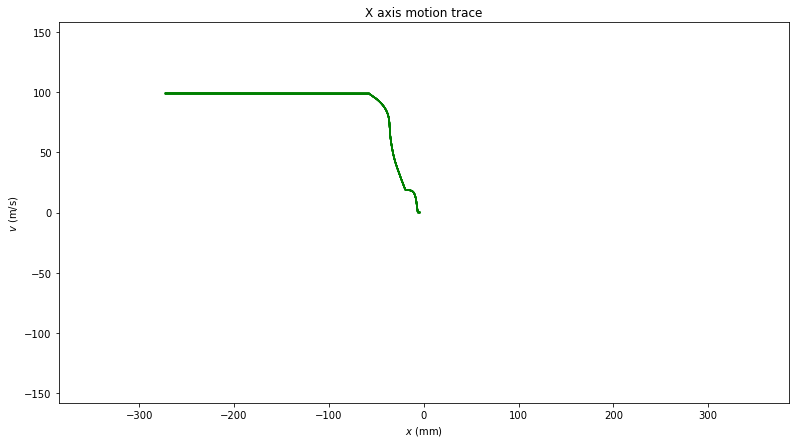

In [75]:
fig, ax = plt.subplots(1, 1,figsize=(13,7))
# plt.imshow(rateeq.profile['F'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$x\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('X axis motion trace')
ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax.set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[0]*x0*1000,sol.v[0]*v0, 'g')
    
# fig.savefig('./MOT/Error.png')
# fig.savefig('./MOT/No Error.png')

In [30]:
laserBeams = Fixed_detune_MgF_MOT(17,120,10,1.2,1.5,300000,400015,intensities,-2.5,0.22,-0.668,-0.4729,-1,-1,1,1)
# laserBeams = pre_Fixed_detune_MgF_MOT(main_detune,white_detune,power_rate_1,power_rate_2,laser_on,laser_off,intensities,-0.5,-0.5,-0.15,-0.5,1,1,1,-1)

In [31]:
zz = np.linspace(-1*z_max,z_max+dz,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)

rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [32]:
# See solve_ivp documentation for event function discussion:
def position_condition(t, y, threshold=1e5):
    if abs(y[-1])<threshold and abs(y[-2])<threshold and abs(y[-3])<threshold:
        val = -1.
    else:
        val = 1.

    return val

def velocity_condition(t, y, threshold=5e-2):
    if abs(y[-4])<threshold and abs(y[-5])<threshold and abs(y[-6])<threshold:
        val = -1.
    else:
        val = 1.

    return val

velocity_condition.terminal=False
position_condition.terminal=False
# conditions =  [velocity_condition,position_condition]
conditions = None

In [33]:
# rateeq.generate_force_profile([Z,Z,np.zeros(Z.shape)],[V,V,np.zeros(V.shape)],name='Fx',progress_bar=1)

In [34]:
# from matplotlib.colors import Normalize

# fig, ax = plt.subplots(1, 1)
# plt.imshow(rateeq.profile['Fx'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
# ax.set_xlabel('$x\ (\mathrm{mm})$')
# ax.set_ylabel('$v\ (\mathrm{m/s})$')
# ax.set_title('X axis motion trace')
# ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
# ax.set_ylim(-1*v_max*v0,v_max*v0)
# fig.subplots_adjust(left=0.12,right=0.9)

# fig.savefig('./MOT/Error2.png')

In [35]:
# np.random.seed(22)

# x_tran = np.random.normal(0,18.7654/v0,15)

# np.random.seed(98)

# y_tran = np.random.normal(0,18.7654/np.sqrt(2)/v0,15)

# # x_tran = np.arange(-0.5,0.5,0.1)
# y_tran = np.arange(-0.5,0.5,0.1)

# print(x_tran)
# # print(y_tran)

In [36]:
x_tran = np.linspace(10,20,11)*1/np.sqrt(2)

In [37]:
sols_rate = list()
v_eval = np.arange(v0_start,v0_end,v0_step)
t_eval = np.arange(t0_start,t0_end,t0_step)

start = time.time()

# for v0a in x_tran:
#     for v0b in y_tran:
#         rateeq.set_initial_position_and_velocity(np.array([0,0.,-1*z_start]),np.array([v0a,v0b,17.7]))
#         rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

#         rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,progress_bar = 1,method='Radau')

#         sols_rate.append(rateeq.sol)
    
# for v0a in x_tran:
#     rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0a/np.sqrt(2),v0a/np.sqrt(2),0.01]))
#     rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

#     rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,progress_bar = 1,method='LSODA',max_step=1000000)

#     sols_rate.append(rateeq.sol)

# for v0a in x_tran:
#     rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0a,v0a,0]))
#     rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

#     rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,progress_bar = 1,method='LSODA')

#     sols_rate.append(rateeq.sol)

rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([17.7/np.sqrt(2),17.7/np.sqrt(2),0.]))
rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,max_step=1e5,progress_bar = 1,method='LSODA')

sols_rate.append(rateeq.sol)


    
print(time.time()-start)

Completed in 32.64 s.                                               
33.05620098114014


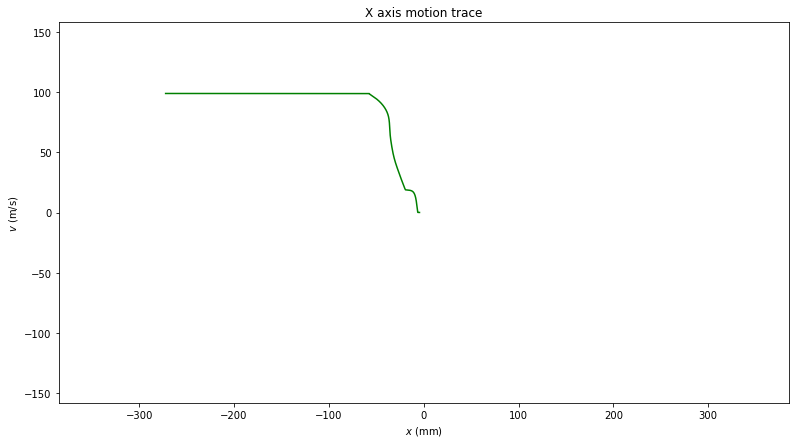

In [38]:
fig, ax = plt.subplots(1, 1,figsize=(13,7))
# plt.imshow(rateeq.profile['F'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$x\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('X axis motion trace')
ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax.set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[0]*x0*1000,sol.v[0]*v0, 'g')
    
# fig.savefig('./MOT/Error.png')
# fig.savefig('./MOT/No Error.png')

In [15]:
sol.r[1][-1]*1000*x0

-4.469678647550871

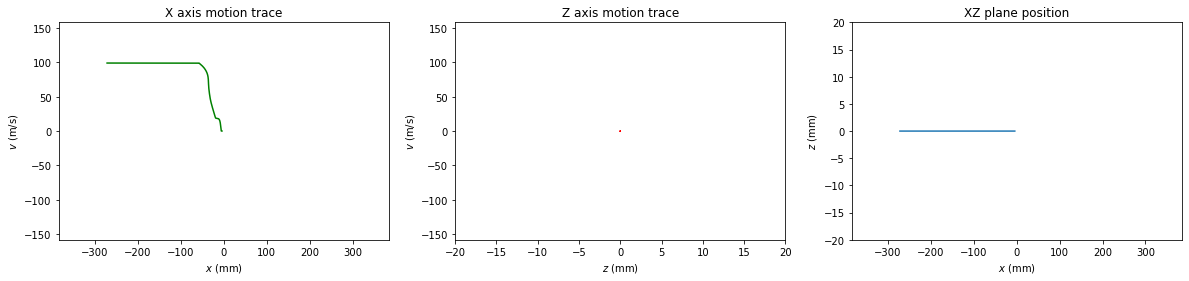

In [16]:
fig, ax = plt.subplots(1, 3,figsize=(20,4))
# plt.imshow(rateeq.profile['F'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax[0].set_xlabel('$x\ (\mathrm{mm})$')
ax[0].set_ylabel('$v\ (\mathrm{m/s})$')
ax[0].set_title('X axis motion trace')
ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[0].set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0, 'g')
    
ax[1].set_xlabel('$z\ (\mathrm{mm})$')
ax[1].set_ylabel('$v\ (\mathrm{m/s})$')
ax[1].set_title('Z axis motion trace')
ax[1].set_xlim(-1*0.020*1000,0.020*1000)
ax[1].set_ylim(-1*v_max*v0,v_max*v0)

for sol in sols_rate:
    ax[1].plot(sol.r[2]*x0*1000,sol.v[2]*v0,'r')
    
ax[2].set_xlabel('$x\ (\mathrm{mm})$')
ax[2].set_ylabel('$z\ (\mathrm{mm})$')
ax[2].set_title('XZ plane position')
ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[2].set_ylim(-1*0.020*1000,0.020*1000)

for sol in sols_rate:
    ax[2].plot(sol.r[0]*x0*1000,sol.r[2]*x0*1000)
    
# fig.savefig('./MOT/Three_plot_2.png')

# Population Part

0.06699323190924394
-4.469683009396615


C:\Users\qmopl\AppData\Local\Temp/ipykernel_15396/617311414.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('./MOT/population plot.png')
C:\Users\qmopl\anaconda3\envs\LCP\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


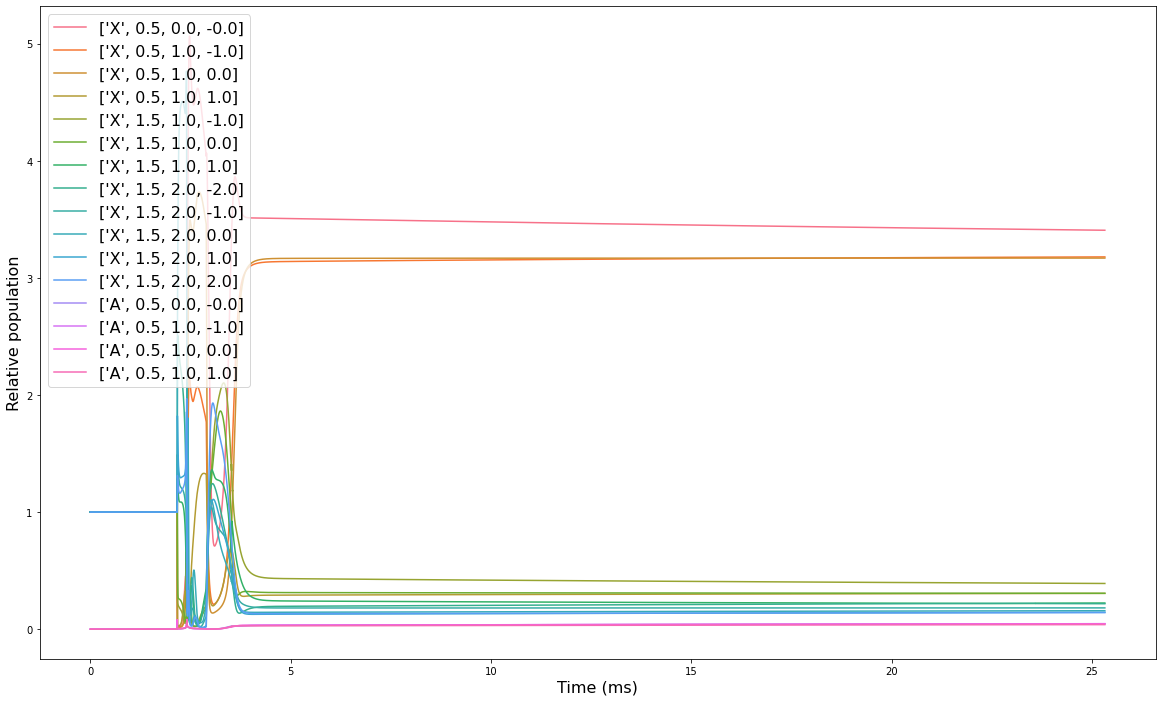

In [17]:
xtick = list()

for basis in Xbasis:
    J = basis[2]
    F = basis[3]
    mF = basis[4]
    xtick.append(['X',J,F,mF])

for basis in Abasis:
    J = basis[2]
    F = basis[4]
    mF = basis[5]
    xtick.append(['A',J,F,mF])

sol = sols_rate[0]
Ns = sol.N

kk = 3500000-10
print(sol.v[1][kk]*v0)
print(sol.r[1][kk]*1000*x0)

Nss = Ns.T

fig, ax = plt.subplots(1,1,figsize=(20,12))
colors = sns.color_palette('husl',len(xtick))

for bas,kk,col in zip(xtick,Ns,colors):
    ax.plot(sol.t*t0*1000,kk,label=bas,color=col)

ax.set_xlabel('Time (ms)',fontsize=16)
ax.set_ylabel('Relative population',fontsize=16)
ax.legend(fontsize=16)
fig.savefig('./MOT/population plot.png')
# ax.set_xlabel(xtick)

In [ ]:
from matplotlib.animation import FuncAnimation
from celluloid import Camera

fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(111)

camera = Camera(fig)

time_steps = np.arange(400000,3000000,20000)



for time_step in tqdm(time_steps):
    ts = int(time_step)
    ax.bar(range(0,16),Nss[ts],color=colors)
    ax.set_xticks(range(len(xtick)))
    ax.set_xticklabels(xtick,fontsize=10)
    fig.subplots_adjust(left=0.12,right=0.9)
    ax.set_xlabel('State',fontsize=20)
    ax.set_ylabel('Relative population',fontsize=20)
    ax.legend()
    
    camera.snap()


animation = camera.animate(interval=50, blit=False)
from IPython.display import HTML
HTML(animation.to_jshtml())

animation.save('./MOT/Population change.gif',writer='imagemagick')

  0%|                                                                                          | 0/130 [00:00<?, ?it/s]No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
  7%|█████▋                                                                            | 9/130 [00:00<00:01, 83.91it/s]No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles

In [ ]:
from matplotlib.animation import FuncAnimation
from celluloid import Camera

fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(111)

camera = Camera(fig)

time_steps = np.arange(130000,400000,1000)

colors = sns.color_palette('hls',len(xtick))

for time_step in tqdm(time_steps):
    ts = int(time_step)
    ax.bar(range(0,16),Nss[ts],color=colors)
    ax.set_xticks(range(len(xtick)))
    ax.set_xticklabels(xtick,fontsize=10)
    fig.subplots_adjust(left=0.12,right=0.9)
    ax.set_xlabel('State',fontsize=20)
    ax.set_ylabel('Relative population',fontsize=20)
    ax.legend()
    
    camera.snap()
    
animation = camera.animate(interval=50, blit=False)

from IPython.display import HTML
HTML(animation.to_jshtml())

animation.save('./MOT/Population change2.gif',writer='imagemagick')

# 3D gif part

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(20,9))
# ax = fig.add_subplot(111,projection='3d')

# ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
# ax.set_ylim(-1*z_max*x0*1000,z_max*x0*1000)
# ax.set_zlim(-1*0.020*1000,0.020*1000)
# ax.view_init(45,90)

# for sol in sols_rate:
#     ax.plot(sol.r[0]*x0*1000,sol.r[1]*x0*1000,sol.r[2]*x0*1000)

In [ ]:
# from matplotlib.animation import FuncAnimation
# from celluloid import Camera

# fig = plt.figure(figsize=(20,9))
# ax = fig.add_subplot(111,projection='3d')

# camera = Camera(fig)

# time_steps = np.arange(0,3000000,20000)

# for time_step in tqdm(time_steps):
#     ts = int(time_step)
#     for sol in sols_rate:
#         ax.plot(sol.r[0][ts]*x0*1000,sol.r[1][ts]*x0*1000,sol.r[2][ts]*x0*1000,'o')
#     ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
#     ax.set_ylim(-1*z_max*x0*1000,z_max*x0*1000)
#     ax.set_zlim(-1*20,20)
#     fig.subplots_adjust(left=0.12,right=0.9)
#     ax.view_init(30,-45)
#     camera.snap()

# animation = camera.animate(interval=50, blit=False)

# from IPython.display import HTML
# HTML(animation.to_jshtml())

# animation.save('./MOT/Slowing and MOT 3D_3.gif',writer='imagemagick')

In [ ]:
# for sol in sols_rate:
#     if len(sol.t_events[0])==1:
#         print(sol.v[2][0],sol.v[0][-1],sol.v[2][-1], sol.r[2][-1],sol.r[0][-1])
#         print('*******')
#         if len(sol.t_events[1])==1:
#             print(sol.v[2][0],sol.v[0][-1],sol.v[2][-1], sol.r[2][-1],sol.r[0][-1],sol.t_events[1])
#             print('------')

In [ ]:
# counts = 0
# for sol in sols_rate:
#     if abs(sol.r[2][-1])<5000 and abs(sol.r[1][-1])<50000 and abs(sol.r[0][-1])<50000:
#         print(sol.v[2][-1], sol.v[0][-1],sol.v[1][-1], sol.r[2][-1], sol.r[0][-1],sol.r[1][-1])
#         counts +=1
        
# print(counts)